In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp

In [2]:
## basic parameters similar to our resonantors

Fs = 10e3 ## sampling rate [Hz]
omega0 = 2*np.pi*35 ## Hz
gamma = 2*np.pi*3 ## Hz
p0 = 200*5.3e-22 ## kg*m/s = 1 MeV/c
kgms_to_MeV = 5.3e-22
m = 2.5e-14 ## 3 um sphere mass, kg
T = 10 ## period
e_charge = 1.6e-19 ## electron charge, C

omega1 = np.sqrt(omega0**2 - gamma**2)

amp = p0/(m*omega1)
tvec = np.arange(0, T, 1/Fs)
t0 = T/2

In [3]:
## function to deconvolve the transfer function to get a force
def reconstructed_force(x, title=""):
    xtilde = np.fft.rfft(x)
    fvec = np.fft.rfftfreq(len(x), 1/Fs)
    omega_vec = 2*np.pi*fvec

    Ftilde = m*xtilde*(omega0**2 - omega_vec**2 - 1j*gamma*omega_vec)

    F = np.fft.irfft(Ftilde)
    gpts = ((tvec-t0) > -1) & ((tvec-t0) < 1) ## window to integrate impulse over
    impulse_amplitude = np.trapz(F[gpts], x=tvec[gpts])
    print("Integrated impulse amplitude: %.1e [kg m/s], %.1f [MeV]"%(impulse_amplitude, impulse_amplitude/kgms_to_MeV))


    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(tvec-t0, x)
    plt.xlim(-0.5,0.5)
    plt.ylabel("Position [m]")

    plt.subplot(2,1,2)
    plt.plot(tvec-t0, F, label="Integral = %.1f [MeV]"%(impulse_amplitude/kgms_to_MeV))
    plt.xlim(-0.5,0.5)
    offset = 0.1*np.max(np.abs(F[gpts]))
    plt.ylim(np.min(F[gpts])-offset, np.max(F[gpts])+offset)
    plt.xlabel("Time [s]")
    plt.ylabel("Force [N]")
    plt.legend()
    plt.suptitle(title)
    plt.show()

    return F, impulse_amplitude

Integrated impulse amplitude: 1.1e-19 [kg m/s], 200.0 [MeV]


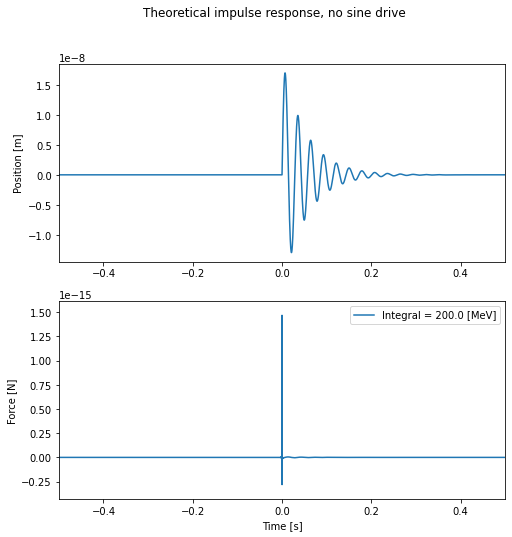

In [4]:
## show we can reconstruct a simple impulse as expected 
x = amp*np.exp(-gamma*(tvec-t0))*(np.sin(omega1*(tvec-t0)))
x[tvec < t0] = 0

F, impulse_amplitude = reconstructed_force(x, title="Theoretical impulse response, no sine drive")

In [5]:
def reconstructed_position(Ftime, title=""):
    Ftilde = np.fft.rfft(Ftime)
    
    fvec = np.fft.rfftfreq(len(Ftime), 1/Fs)
    omega_vec = 2*np.pi*fvec

    xtilde = Ftilde/(m*(omega0**2 - omega_vec**2 + 1j*gamma*omega_vec))
    x = np.fft.irfft(xtilde)

    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(tvec-t0, x)
    plt.xlim(-0.5,0.5)
    plt.ylabel("Position [m]")

    plt.subplot(2,1,1)
    plt.plot(tvec-t0, Ftime)
    plt.xlim(-0.5,0.5)
    plt.xlabel("Time [s]")
    plt.ylabel("Force [N]")
    plt.suptitle(title)
    plt.show()

    return x

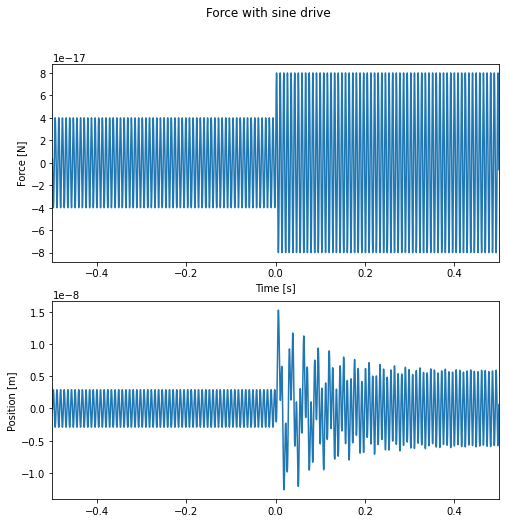

In [6]:
## now let's go the other way -- make a force and reconstruct the time domain from it
fdrive = 123 ## Drive freq in Hz
omega_drive = 2*np.pi*fdrive
Vdrive = 10 ## voltage drive amplitude [V]
d = 4e-2 ## electrode separation [m]

step_function = np.ones_like(tvec)
step_function[tvec > t0] = 2

Ftime = (e_charge*Vdrive/d)*np.sin(omega_drive*tvec)*step_function

x = reconstructed_position(Ftime, title="Force with sine drive")


Integrated impulse amplitude: -4.1e-22 [kg m/s], -0.8 [MeV]


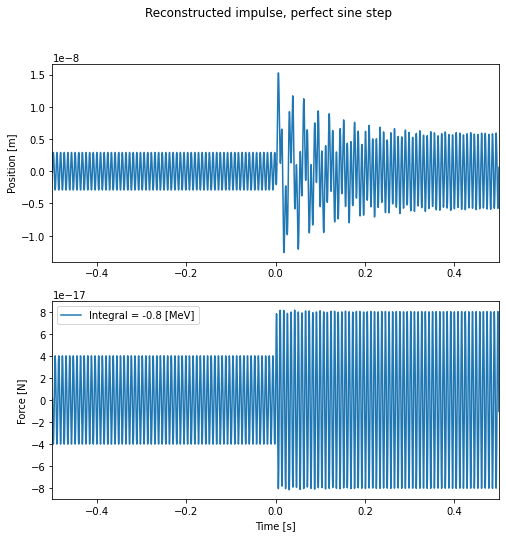

In [7]:
## now try various reconstructions

## no filter
F, impulse_amplitude = reconstructed_force(x, title="Reconstructed impulse, perfect sine step")

Integrated impulse amplitude: 5.2e-20 [kg m/s], 97.6 [MeV]


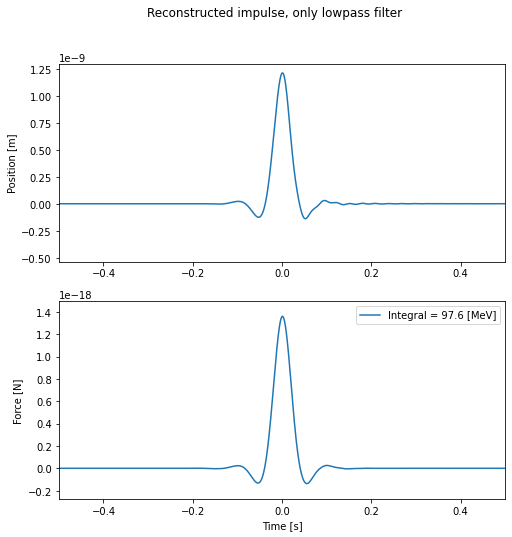

In [8]:
## simple low pass filter
ffilt = 50
b, a = sp.butter(3, ffilt/(2*Fs), btype="lowpass")
xfilt = sp.filtfilt(b,a,x)

F, impulse_amplitude = reconstructed_force(xfilt, "Reconstructed impulse, only lowpass filter")

In [9]:
def correlation_recon(x):
    tt = np.arange(-0.5,0.5,1/Fs)
    template_x = np.exp(-gamma*tt)*(np.sin(omega1*tt))
    template_x[tt < 0] = 0

    corr_out = sp.correlate(x,template_x,mode='same')/np.sum(template_x**2)

    return corr_out * (m*omega1)/kgms_to_MeV

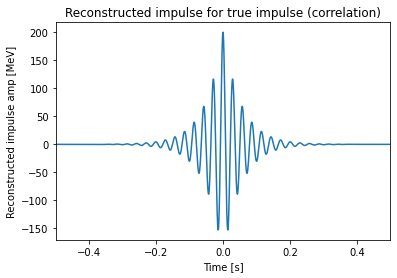

In [10]:
## Double check this works as expected with the correlation 
x = amp*np.exp(-gamma*(tvec-t0))*(np.sin(omega1*(tvec-t0)))
x[tvec < t0] = 0

xcorr = correlation_recon(x)

plt.figure()
plt.plot(tvec-t0,xcorr)
plt.xlim(-0.5,0.5)
plt.xlabel("Time [s]")
plt.ylabel("Reconstructed impulse amp [MeV]")
plt.title("Reconstructed impulse for true impulse (correlation)")
plt.show()

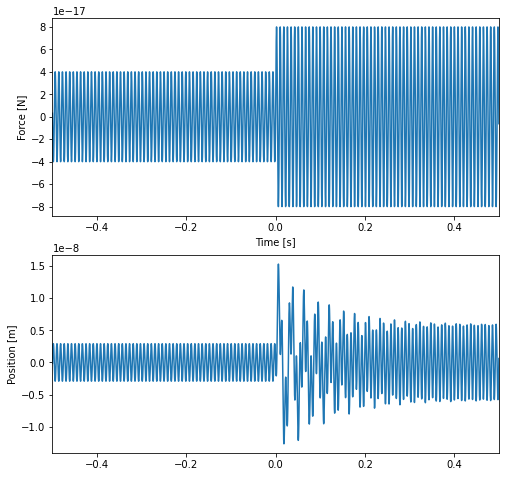

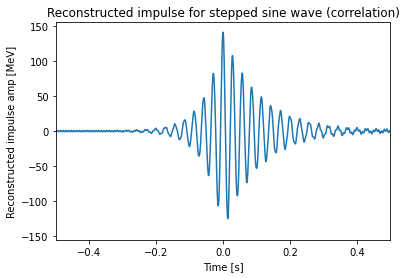

In [11]:
## Now the stepped sine wave
x = reconstructed_position(Ftime)
xcorr = correlation_recon(x)

plt.figure()
plt.plot(tvec-t0,xcorr)
plt.xlim(-0.5,0.5)
plt.xlabel("Time [s]")
plt.ylabel("Reconstructed impulse amp [MeV]")
plt.title("Reconstructed impulse for stepped sine wave (correlation)")
plt.show()

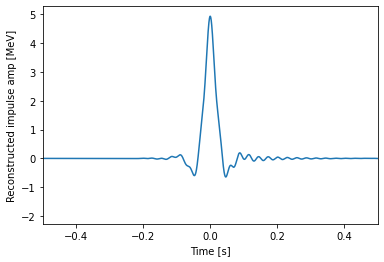

In [12]:
## Now the stepped (and filtered) sine wave
ffilt = 50
b, a = sp.butter(3, ffilt/(2*Fs), btype="lowpass")
xfilt = sp.filtfilt(b,a,x)
xcorr = correlation_recon(xfilt)

plt.figure()
plt.plot(tvec-t0,xcorr)
plt.xlim(-0.5,0.5)
plt.xlabel("Time [s]")
plt.ylabel("Reconstructed impulse amp [MeV]")
plt.show()